
## Teleconnection between ENSO and Precipitation

<p>Linear regression is applied to analyse the association between the climatic components (sea surface temperature (SST), precipitaion, sea level pressure, wind vector etc.) and large climate scale (i.e. El Niño Southern Oscillation (ENSO), Indian Ocean Dipole(IOD)). In this notebook, we will compute the correlation between ENSO and precipitation.</p>

<p>To compute the ENSO associated correlation, the Niño 3.4 index is used. The Niño 3.4 index is commonly used indices to define El Niño and La Niña events. See more about SST index at <a href="https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni">this website</a>.</p>

<p>Data sources:</p>

<ul>
  <p><li><em><strong>SST</strong></em></li><br>
    <ul>
    <li>Data: NOAA Extended Reconstructed SST V5</li><br>
    <li>Temporal coverage: Monthly values for 1854/01- 2022/06</li><br>
    <li>Spatial coverage: 2.0&deg; latitude x 2.0&deg; longitude global grid (89x180); 88 &deg;N - 88 &deg;S, 0 &deg;E - 358 &deg;E</li><br>
    <li>See more at <a href="https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html">https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html</a>.</li></p>
    </ul>
  <p><li><em><strong>Precipitation</strong></em></li><br>
    <ul>
    <li>Data: CMAP Precipitation</li><br>
    <li>Temporal coverage: Monthly values 1979/01 to 2022/06</li><br>
    <li>Spatial coverage: 2.5&deg; latitude x 2.5&deg; longitude global grid (144x72); 88.75 &deg;N - 88.75 &deg;S, 1.25 &deg;E - 358.75 &deg;E</li><br>
    <li>See more at <a href="https://psl.noaa.gov/data/gridded/data.cmap.html">https://psl.noaa.gov/data/gridded/data.cmap.html</a>.</li></p>
    </ul>
</ul>

### 0. Preprocessing data using Climate Data Operator (CDO)

<p><strong>Create file named <em>mygrid</em> with desired grid type and grid size.</strong></p>

> <p>cat > mygrid << EOF<br>
> gridtype = lonlat<br>
> xsize    = 360<br>
> ysize    = 180<br>
> xfirst   = -179.5<br>
> xinc     = 1<br>
> yfirst   = -89.5<br>
> yinc     = 1<br>
> EOF</p>

<p><strong>Regrid the data and create a new data file.</strong></p>

> cdo remapbil,mygrid infile.nc outfile.nc

<p><strong>Change calendar type to <em>standard</em>.</strong></p>

> cdo -f nc setcalendar,standard infile.nc outfile.nc

<p><strong>Convert unit of precipitation from kg/m2/s1 to mm/day (if necessary).</strong></p>

> cdo -setunit,mm/day -mulc,86400 infile.nc outfile.nc

### 1. Load basic library


In [38]:

import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10
import warnings
warnings.filterwarnings('ignore')



### 2. Define function to calculate linear regression


In [39]:

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(np.abs(tstats), n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr


### 3. Import and read data files

In [40]:

# import data files
filetmp = 'sst.mnmean_regrid.nc'
fileprc = 'precip.mon.mean_regrid.nc'

# open file
ds_sst = xr.open_dataset(filetmp)
ds_prc = xr.open_dataset(fileprc)



### 4. Reassign latitude longitude (if necessary)

<p>Precipitation data</p>


In [41]:

# shift from -180 180  to 0 360
# assign longitude
lon = ds_prc.lon[:]
lon_name = 'lon'  # whatever name is in the data

# Adjust lon values to make sure they are within (0,360)
ds_prc['_longitude_adjusted'] = xr.where(
    ds_prc[lon_name] < 0,
    ds_prc[lon_name] + 360,
    ds_prc[lon_name])

# reassign the new coords to as the main lon coords and sort DataArray using new coordinate values
ds_prc = (
    ds_prc
    .swap_dims({lon_name: '_longitude_adjusted'})
    .sel(**{'_longitude_adjusted': sorted(ds_prc._longitude_adjusted)})
    .drop(lon_name))

#reassign data to match new lon
ds_prc = ds_prc.rename({'_longitude_adjusted': lon_name})
prc = ds_prc.precip.sel(time=slice('1980',None))



SST data


In [42]:

# shift from -180 180 to 0 360
# assign longitude
lon = ds_sst.lon[:]
lon_name = 'lon'  # whatever name is in the data

# Adjust lon values to make sure they are within (0,360)
ds_sst['_longitude_adjusted'] = xr.where(
    ds_sst[lon_name] < 0,
    ds_sst[lon_name] + 360,
    ds_sst[lon_name])

# reassign the new coords to as the main lon coords and sort DataArray using new coordinate values
ds_sst = (
    ds_sst
    .swap_dims({lon_name: '_longitude_adjusted'})
    .sel(**{'_longitude_adjusted': sorted(ds_sst._longitude_adjusted)})
    .drop(lon_name))

#reassign data to match new lon
ds_sst = ds_sst.rename({'_longitude_adjusted': lon_name})
sst = ds_sst.sst.sel(time=slice('1980',None))



### 5. Compute the Nino 3.4 Index

<p>Nino 3.4 Index is the SST averaged over 5 &deg;S - 5 &deg;N and 120&deg;W - 170&deg;W.</p>


In [43]:

# get nino3.4 region
sst_nino34 = sst.where((sst.lat<5) & (sst.lat>-5) & (sst.lon>190) & (sst.lon<240), drop=True)
# sst_nino34 = sst.where((sst.lat<5) & (sst.lat>-5) & (sst.lon>-170) & (sst.lon<-120), drop=True) # if you're using longitude -180 to 180

# calculate climatology
# slice time from 1980 to 2020
sst_nino34_climatology = sst_nino34.sel(time=slice('1980','2020')).groupby('time.month').mean(dim=['lat','lon','time'])

# calculate nino3.4 index
index_nino34 = (sst_nino34.groupby('time.month')-sst_nino34_climatology).mean(dim=['lat','lon'])



### 6. Correlate the calculated Nino 3.4 with precipitation

<p>Using the defined <code>lag_linregress_3D</code> function to compute the correlation.</p>


In [44]:

# correlate precipitation with nino 3,4 index
cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=prc,y=index_nino34)



### 7. Plotting

<p>Choose your desire <code>matplotlib</code> colormap to best show your representation. Further details can be found at <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html">https://matplotlib.org/stable/tutorials/colors/colormaps.html</a>.</p>


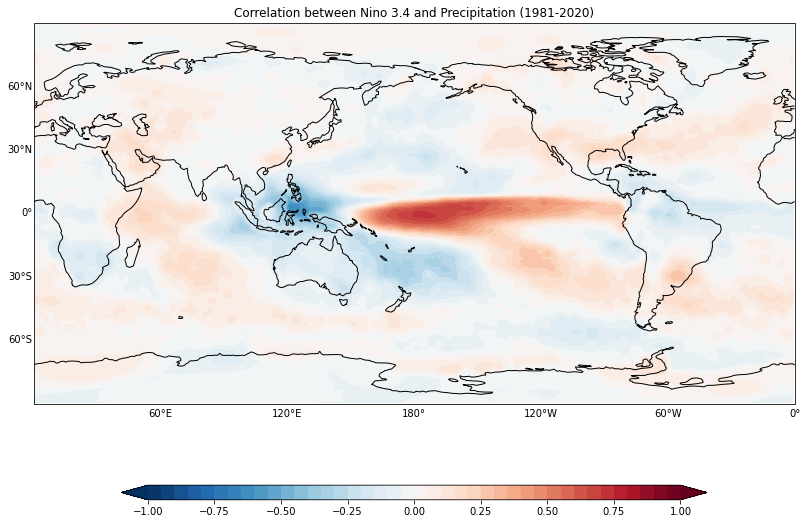

In [45]:

fig, ax = plt.subplots()
levels = np.linspace(-1., 1.0, 41) # set colorbar range and intervals

lons, lats = np.meshgrid(cor.lon, cor.lat)
ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-180))
ax1.set_extent([0, 360, -90, 90], crs=ccrs.PlateCarree()) # Plot desire subregion
im1 = ax1.contourf(lons, lats, cor, levels=levels, 
                    transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both') 
ax1.coastlines() # add coastlines
gl1 = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),linestyle='--', alpha=0) # draw latlon labels
gl1.top_labels = False # remove top labels
gl1.right_labels = False # remove right labels
ax1.set_title('Correlation between Nino 3.4 and Precipitation (1981-2020)', fontsize=12) # set title

# colorbar
fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=0.7, aspect=40)



#### To hatch the significant area

<p>The <strong>0.09</strong> and <strong>-0.09</strong> are the correlation critical values for 480 sample size, 1981 to 2020 are 40 years monthly data, 40 years &times; 12 months each year = 480 timesteps.</p>

<p>Critical values can be calculated from <a href="https://mathcracker.com/critical-correlation-calculator">here</a>.</p>

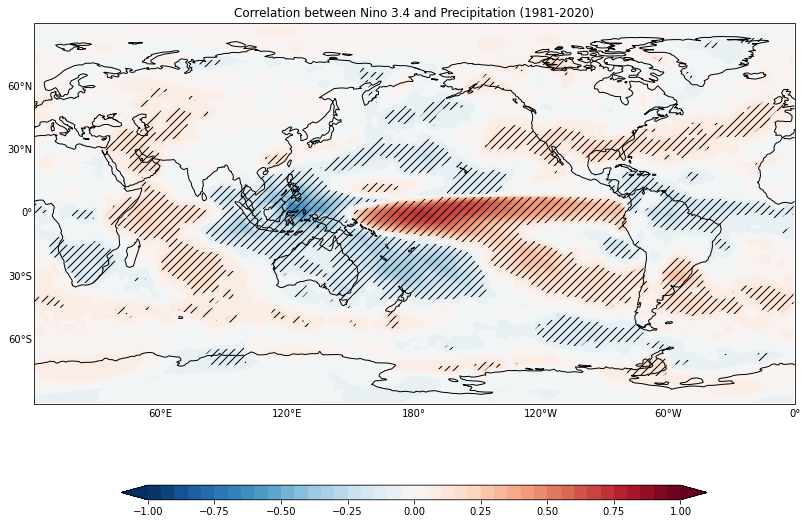

In [46]:

fig, ax = plt.subplots()
levels = np.linspace(-1., 1.0, 41)

# get the significant area
zm1 = np.ma.masked_where((cor <= 0.09) & (cor >= -0.09), cor) 

lons, lats = np.meshgrid(cor.lon, cor.lat)
ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=-180))
ax1.set_extent([0, 360, -90, 90], crs=ccrs.PlateCarree()) # Plot desire subregion
im1 = ax1.contourf(lons, lats, cor, levels=levels, 
                    transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')
ax1.contourf(lons, lats, zm1, hatches=['///'], alpha=0, transform=ccrs.PlateCarree()) # hatch significant area
ax1.coastlines() # draw coastline
gl1 = ax1.gridlines(draw_labels=True,crs=ccrs.PlateCarree(),linestyle='--', alpha=0) # draw latlon labels
gl1.top_labels = False # remove top labels
gl1.right_labels = False # remove right labels
ax1.set_title('Correlation between Nino 3.4 and Precipitation (1981-2020)', fontsize=12)

# colorbar
fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=0.7, aspect=40)



#### Save figure


In [47]:

plt.savefig('/fig-teleconnection.png', bbox_inches='tight', pad_inches = 0.1, dpi = 300)



#### Remark

<p>The correlation between Nino 3.4 and precipitation illustrate the ENSO teleconnection patterns. There is a tendency for above (below) normal rainfall during El Niño (La Niña) events over Eastern Africa, Saudi Arabia, Southern South America, Southern North America (Southern Africa, Southeast Asia, Northen South America). These extremes (above or below) in rainfall will influence regional climate and provide implication for regional adaptation and mitigation.</p> 

### 8. Calculate the significant grid area

<p>First get the significant location at desired region, here we use the South America region, 90 &deg;W - 40 &deg;W and 60 &deg;S - 10 &deg;N.</p>


In [48]:
# get the significant area
sig_area   = np.where(cor > 0.09)
sig_area1   = np.where(cor < -0.09) 

# convert into dataframe
dfSigArea_Pos = pd.DataFrame(sig_area).T
dfSigArea_Pos.rename(columns={0: "lat", 1: "lon"},inplace=True)

dfSigArea_Neg = pd.DataFrame(sig_area1).T
dfSigArea_Neg.rename(columns={0: "lat", 1: "lon"},inplace=True)

# merge xy coordinate to lonlat
dfSigArea_Pos['lat'] = dfSigArea_Pos['lat']-90.5
dfSigArea_Pos['lon'] = dfSigArea_Pos['lon']-0.5

dfSigArea_Neg['lat'] = dfSigArea_Neg['lat']-90.5
dfSigArea_Neg['lon'] = dfSigArea_Neg['lon']-0.5

# select significant points in SEA region
dfSigArea_Pos1 = dfSigArea_Pos[(dfSigArea_Pos['lat']>-60) & (dfSigArea_Pos['lat']<10) & (dfSigArea_Pos['lon']>270) & (dfSigArea_Pos['lon']<320)]
dfSigArea_Neg1 = dfSigArea_Neg[(dfSigArea_Neg['lat']>-60) & (dfSigArea_Neg['lat']<10) & (dfSigArea_Neg['lon']>270) & (dfSigArea_Neg['lon']<320)]



<p>Then compute the area of coverage using simple equation:</p>


$$PCENT_{P} = \frac{Area_{P}}{Area_{Total}} \times 100\%$$
$$PCENT_{N} = \frac{Area_{N}}{Area_{Total}} \times 100\%$$

<p>Where PCENT<sub>P</sub> (PCENT<sub>N</sub>) is the percentage of positive (negative) significant area, Area<sub>P</sub> (Area<sub>N</sub>) refers to the number of positive (negative) significant grid and Area<sub>Total</sub> is the total area of grids grid<sub>horizontal</sub> &times; grid<sub>vertical</sub> in the plot.</p>


In [49]:

# total number of significant grid divide by total coverage area (lat50*lon50)
area_SigAPos = (len(dfSigArea_Pos1.index)/2500)*100
area_SigANeg = (len(dfSigArea_Neg1.index)/2500)*100

print("Positive significant coverage area = " +  "{:0.2f}".format(area_SigAPos))
print("Negative significant coverage area = " +  "{:0.2f}".format(area_SigANeg))


Positive significant coverage area = 36.72
Negative significant coverage area = 32.20



#### Remark

<p>We know that there are 36.72% of South America influenced by the above normal rainfall during El Nino, and 32.20% of it affected by the below normal rainfall during La Nina.


### Reference

Trenberth, K. E., 1997: The definition of El Niño. Bulletin of the American Meteorological Society, 78(12), 2771 – 2778.
